In [10]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [14]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import tensorflow as td
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [9]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
EPOCHS = 100

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/dataset",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,

    image_size=IMAGE_SIZE)

Found 11994 files belonging to 6 classes.


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
from tensorflow.keras import models, layers


data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




In [ ]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(6, activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:

# view the structure of the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [ ]:
"/content/drive/My Drive/dataset"

'/content/drive/My Drive/dataset'

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0018002685 0.9893953


In [ ]:
normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.011664668 0.6927375


In [ ]:
normalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00060021627 0.97935176


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs= EPOCHS  
)

Epoch 1/100
300/300 [==============================] - 81s 256ms/step - loss: 46.0789 - accuracy: 0.5974 - val_loss: 26.9756 - val_accuracy: 0.7052
Epoch 2/100
300/300 [==============================] - 79s 264ms/step - loss: 28.1960 - accuracy: 0.7112 - val_loss: 29.5393 - val_accuracy: 0.7297
Epoch 3/100
300/300 [==============================] - 80s 267ms/step - loss: 25.8816 - accuracy: 0.7553 - val_loss: 16.9224 - val_accuracy: 0.7889
Epoch 4/100
300/300 [==============================] - 82s 273ms/step - loss: 19.2419 - accuracy: 0.8011 - val_loss: 20.9913 - val_accuracy: 0.8007
Epoch 5/100
300/300 [==============================] - 82s 273ms/step - loss: 17.8643 - accuracy: 0.8162 - val_loss: 10.2105 - val_accuracy: 0.8750
Epoch 6/100
300/300 [==============================] - 82s 274ms/step - loss: 16.6020 - accuracy: 0.8361 - val_loss: 11.9136 - val_accuracy: 0.8590
Epoch 7/100
300/300 [==============================] - 80s 267ms/step - loss: 15.6390 - accuracy: 0.8437 - val_l

In [ ]:
scores = model.evaluate(test_ds)

38/38 [==============================] - 9s 234ms/step - loss: 18.0428 - accuracy: 0.9597


In [13]:


type(history.history['loss'])
len(history.history['loss'])
history.history['loss'][:5] # show loss for first 5 epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

In [17]:
class_names = dataset.class_names
class_names

['Cryptogamique',
 'Fumagine',
 'Healthy',
 'Maladie bactériennes',
 'Mildiou',
 'Septoriose']

first image to predict
actual label: Septoriose
predicted label: Septoriose


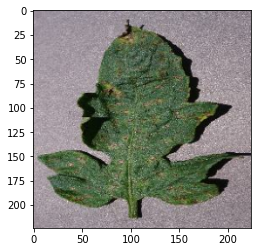

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

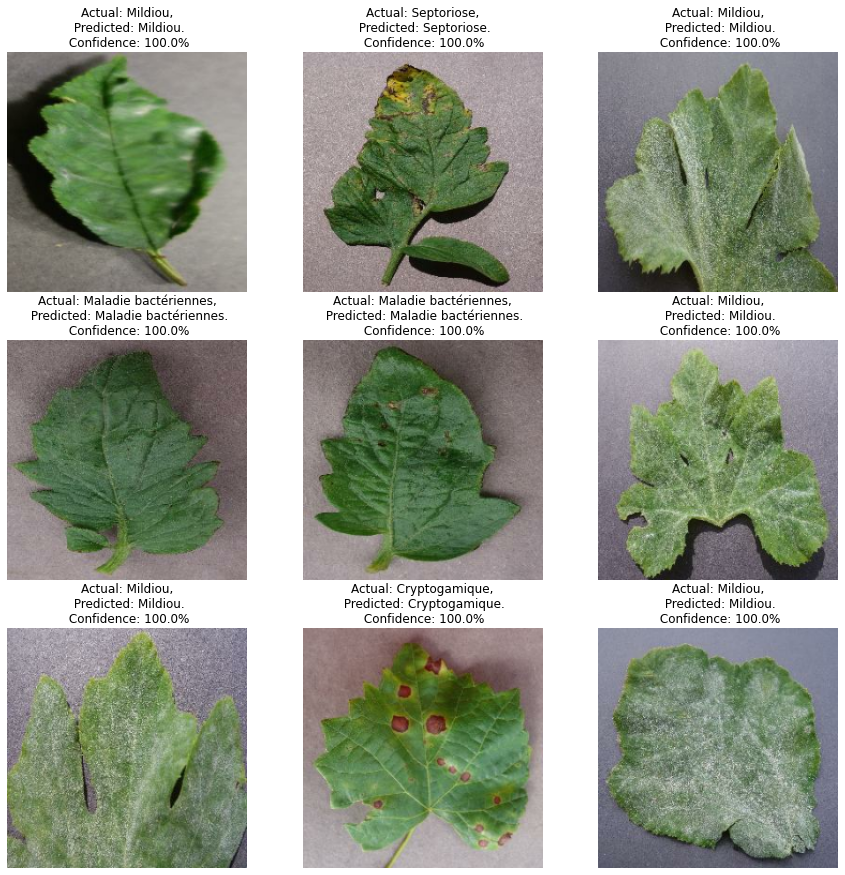

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
model.save("/content/drive/My Drive/disease_plant_transfer.h5")

[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.1972414e-31
 0.0000000e+00]
confidence 100.0
This image belongs to Cryptogamique.


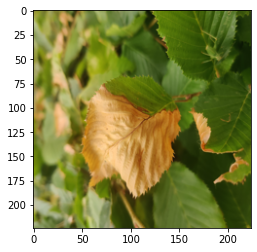

In [19]:
model = tf.keras.models.load_model("/content/drive/My Drive/disease_plant_transfer.h5")
import numpy as np
from PIL import Image

image = '/content/drive/My Drive/Sarah/test_images/IMG_20220622_195050.jpg'

image = np.array(
    Image.open(image).convert("RGB").resize(IMAGE_SIZE) # image resizing
)



image = image/255.0 # normalize the image in 0 to 1 range
img_array = tf.expand_dims(image, 0)


img_array.numpy().astype('uint8')

predictions = model.predict(img_array)

print(predictions[0])
plt.imshow(image)

confidence = round(100 * (np.max(predictions[0])), 2)
print("confidence",confidence)
print("This image belongs to {}.".format(class_names[np.argmax(predictions[0])])) 